In [1]:
import scimap as sm
import pandas as pd
import anndata as ad
import numpy as np

Running SCIMAP  2.1.3


In [2]:
path_to_quant = "/Volumes/RD_Coscia/Jose/P26_BCCN/P26E11_Gating_993/quant/993.csv"
df = pd.read_csv(path_to_quant)

meta_columns = ['CellID', 'Y_centroid', 'X_centroid',
    'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
    'Orientation', 'Extent', 'Solidity']

metadata = df[meta_columns]
data = df.drop(columns=meta_columns)
variables = pd.DataFrame(
    index=data.columns,
    data={"math": [column_name.split("_")[0] for column_name in data.columns],
        "marker": ["_".join(column_name.split("_")[1:]) for column_name in data.columns]})

adata = ad.AnnData(X=data.values, obs=metadata, var=variables)
adata

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.



AnnData object with n_obs × n_vars = 304243 × 75
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity'
    var: 'math', 'marker'

In [3]:
type(adata)

anndata._core.anndata.AnnData

In [4]:
gates = pd.read_csv("/Volumes/RD_Coscia/Jose/P26_BCCN/P26E11_Gating_993/gates/20240905_gates.csv")
gates = gates[gates.gate_value != 0.0]

In [5]:
gates

sample_id      marker_id  gate_value
20        993  mean_Vimentin  360.000000
21        993      mean_CD3e  265.888773
22        993     mean_panCK  235.000000
23        993       mean_CD8  720.000000
25        993    mean_COL1A1  269.463533
26        993      mean_CD20  215.000000
27        993      mean_CD68   65.614527
28        993      mean_Ki67  277.907329

In [4]:
adata = adata[:, gates.marker_id]

In [5]:
adata.raw = adata
adata = sm.pp.log1p(adata)
adata.write("/Volumes/RD_Coscia/Jose/P26_BCCN/P26E11_Gating_993/quant/20240905_993_gate_filtered.h5ad")
adata.obs['imageid'] = "993"

In [6]:
# normalize gates to log1p
gates['log1p_gate_value'] = np.log1p(gates.gate_value)
gates_for_scimap = gates[['marker_id', 'log1p_gate_value']]
gates_for_scimap.rename(columns={'marker_id': 'marker', 'log1p_gate_value': '993'}, inplace=True)

/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_23655/3840965615.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



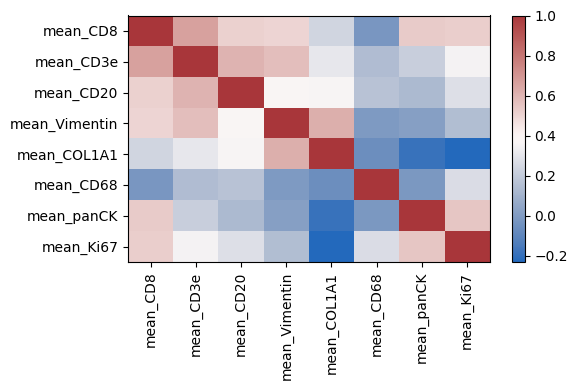

In [11]:
sm.pl.markerCorrelation(adata, figsize=(6,4))

In [7]:
adata = sm.pp.rescale(adata, gate=gates_for_scimap, log=True, verbose=True)

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/preprocessing/rescale.py:105: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Scaling Image 993
Scaling mean_Vimentin
Scaling mean_CD3e
Scaling mean_panCK
Scaling mean_CD8
Scaling mean_COL1A1
Scaling mean_CD20
Scaling mean_CD68
Scaling mean_Ki67


Phenotyping Cancer_cells
Phenotyping T_cells
Phenotyping Vimentin_cells
Phenotyping COL1A1_cells
Phenotyping B_cells
Phenotyping Macrophages
-- Subsetting T_cells
Phenotyping CD4_Tcells
Phenotyping CD8_Tcells
Consolidating the phenotypes across all groups


/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



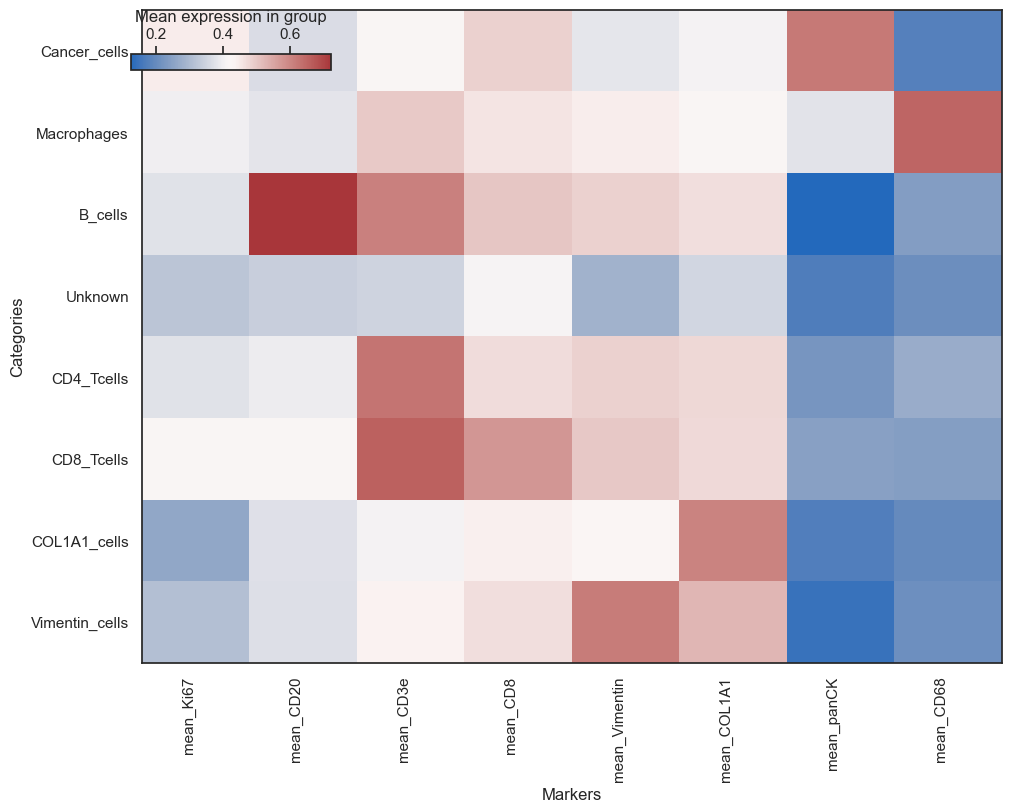

In [8]:
phenotype_matrix_v3 = pd.read_csv("/Volumes/RD_Coscia/Jose/P26_BCCN/P26E11_Gating_993/20240905_PhenotypeMatrix_v3.csv")
sm.tl.phenotype_cells(adata, phenotype=phenotype_matrix_v3, label="phenotype")
sm.pl.heatmap(adata, groupBy='phenotype', saveDir=None, fileName=None)

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/plotting/umap.py:270: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



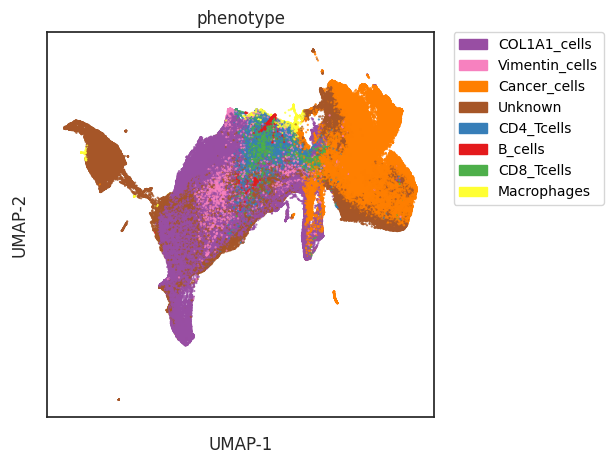

In [9]:
adata = sm.tl.umap(adata)
sm.pl.umap(adata, color=['phenotype'])

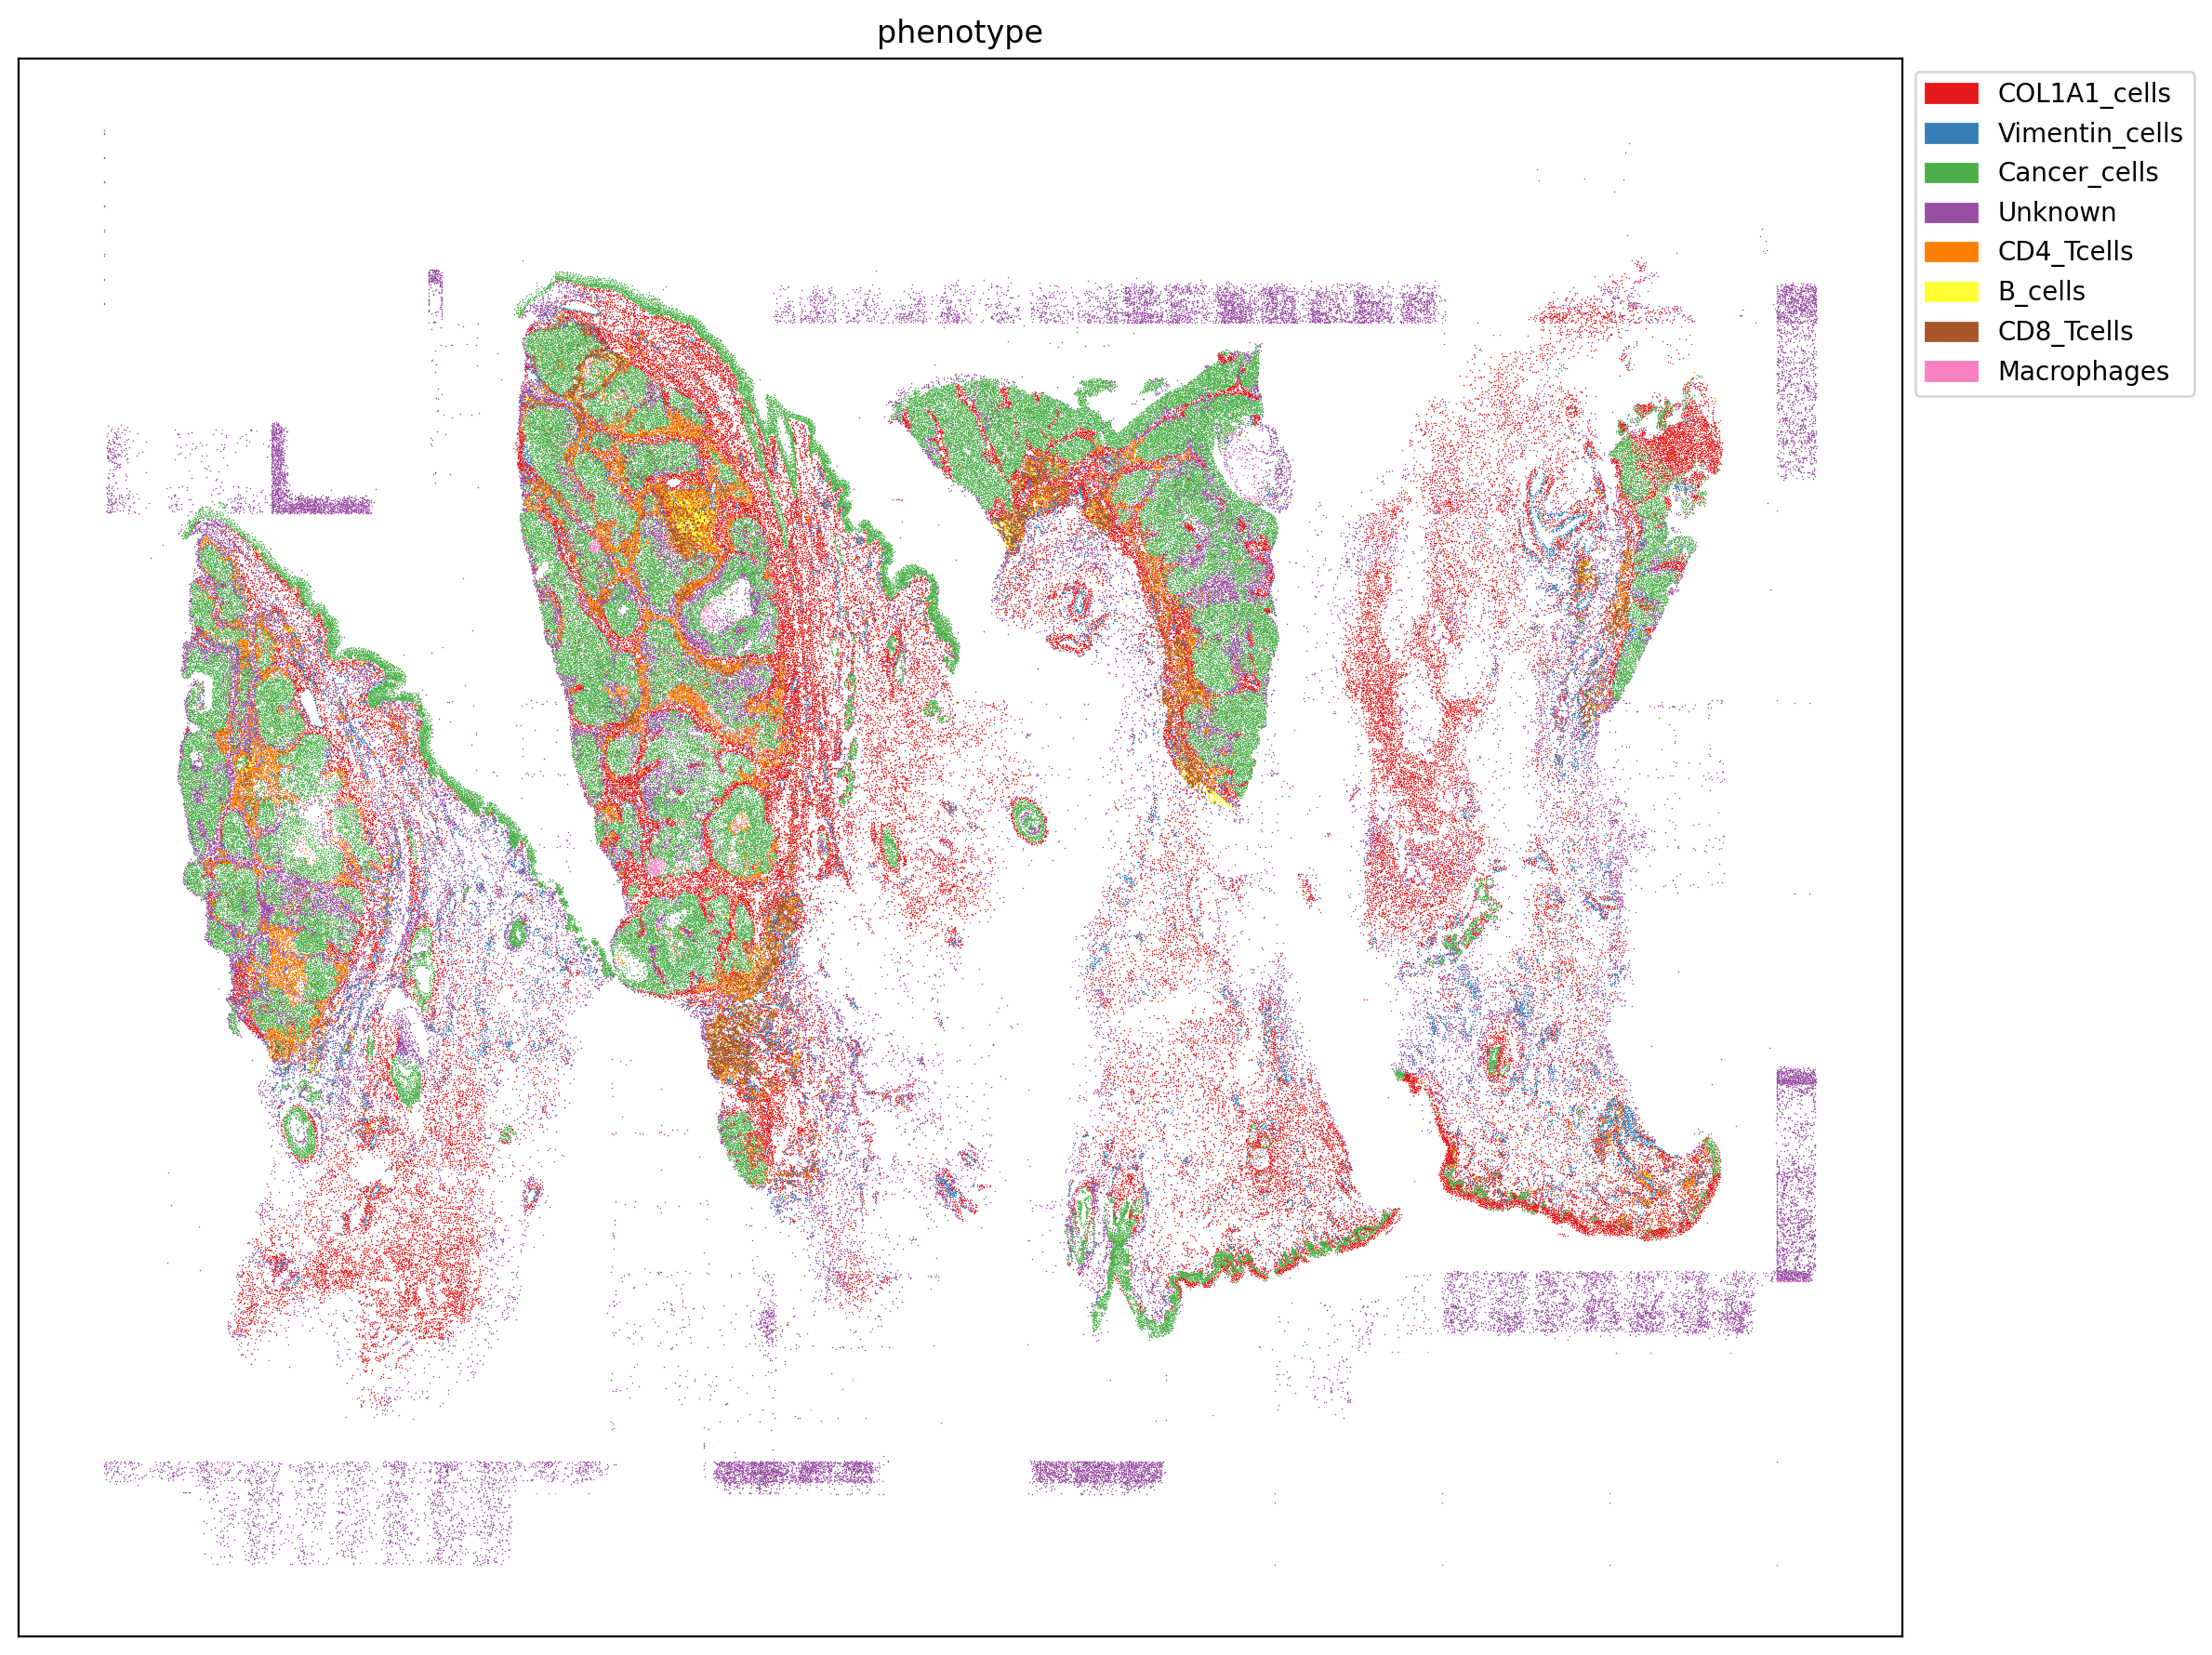

In [10]:
sm.pl.spatial_scatterPlot (adata, colorBy = ['phenotype'],figsize=(12,9), s=0.3, fontsize=10, catCmap='Set1')

Processing Image: 993


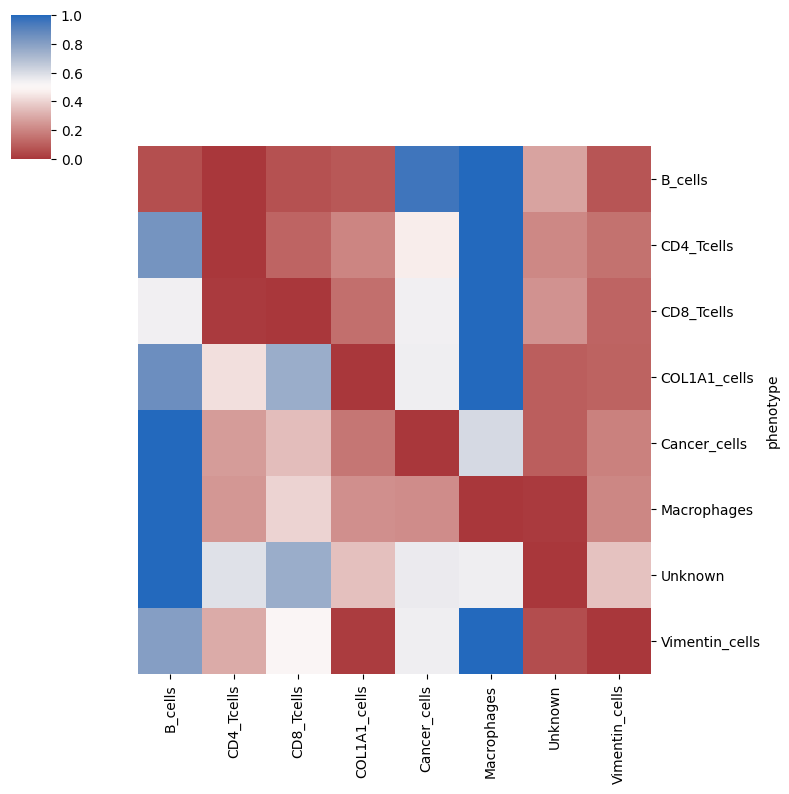

In [12]:
adata = sm.tl.spatial_distance (adata, phenotype='phenotype')
sm.pl.spatial_distance (adata, figsize=(8,8))

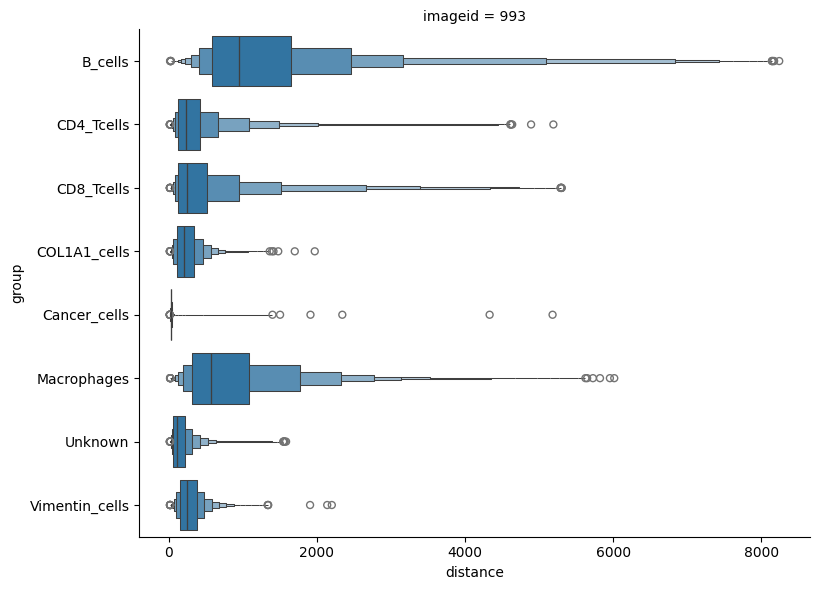

In [14]:
sm.pl.spatial_distance (adata, method='numeric',distance_from='Cancer_cells', height=6, aspect=11/8)

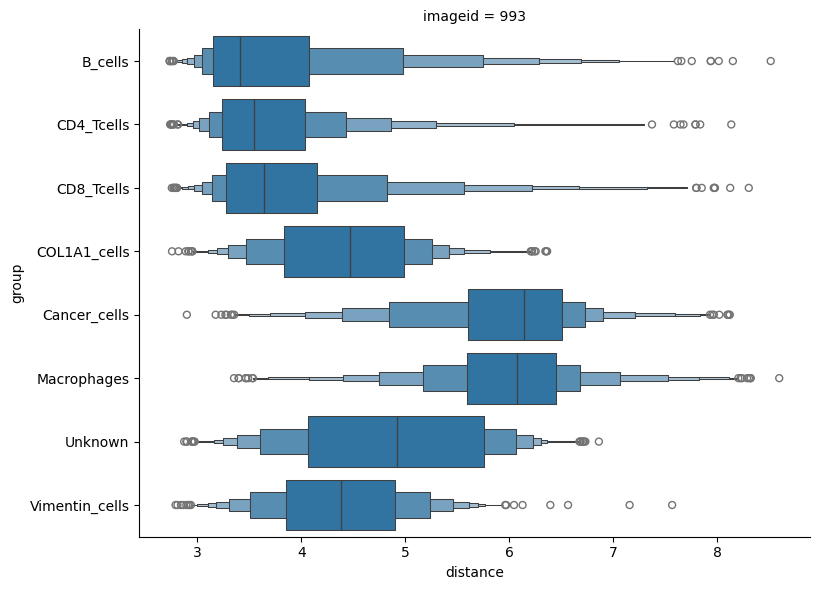

In [15]:
sm.pl.spatial_distance (adata, method='numeric',distance_from='B_cells', log=True, height=6, aspect=11/8)


In [16]:
adata = sm.tl.spatial_interaction (adata, 
                                method='knn', 
                                radius=10, 
                                label='spatial_interaction_knn')

Processing Image: ['993']
Identifying the 10 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


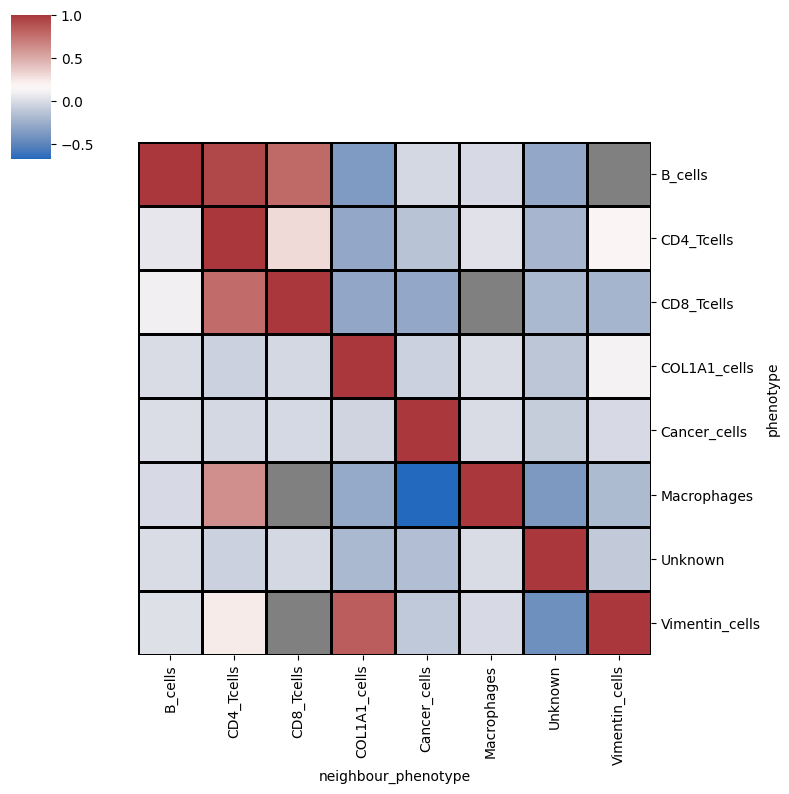

In [17]:
sm.pl.spatial_interaction(adata, 
                        spatial_interaction='spatial_interaction_knn',
                        linewidths=0.75, linecolor='black', figsize=(8,8))

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9694: RuntimeWarning:

divide by zero encountered in log



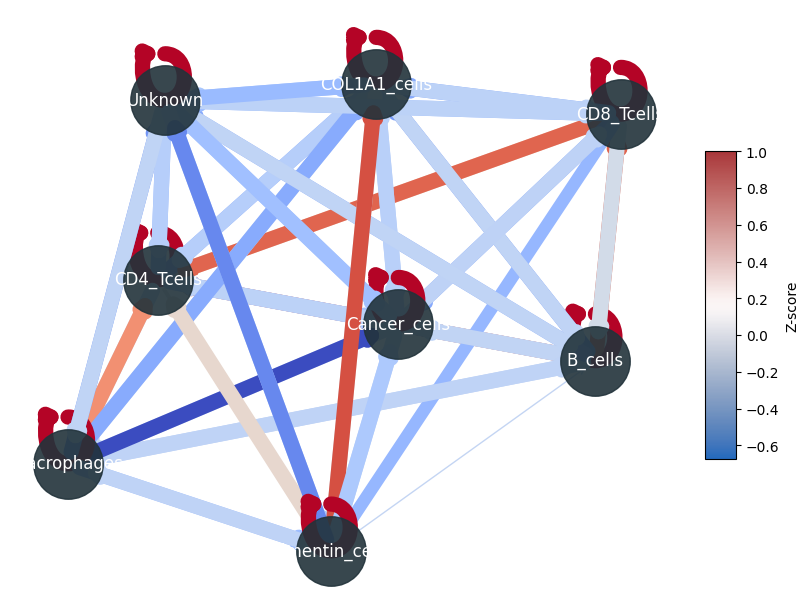

In [18]:
sm.pl.spatialInteractionNetwork(adata, spatial_interaction='spatial_interaction_knn', figsize=(8,6))

In [19]:
adata = sm.tl.spatial_count(adata, phenotype='phenotype', method='knn', radius=12, label='spatial_count')

Identifying the 10 nearest neighbours for every cell


In [20]:
adata = sm.tl.spatial_cluster(adata, df_name='spatial_count', method='kmeans', k=7, label='neigh_kmeans')

Kmeans clustering


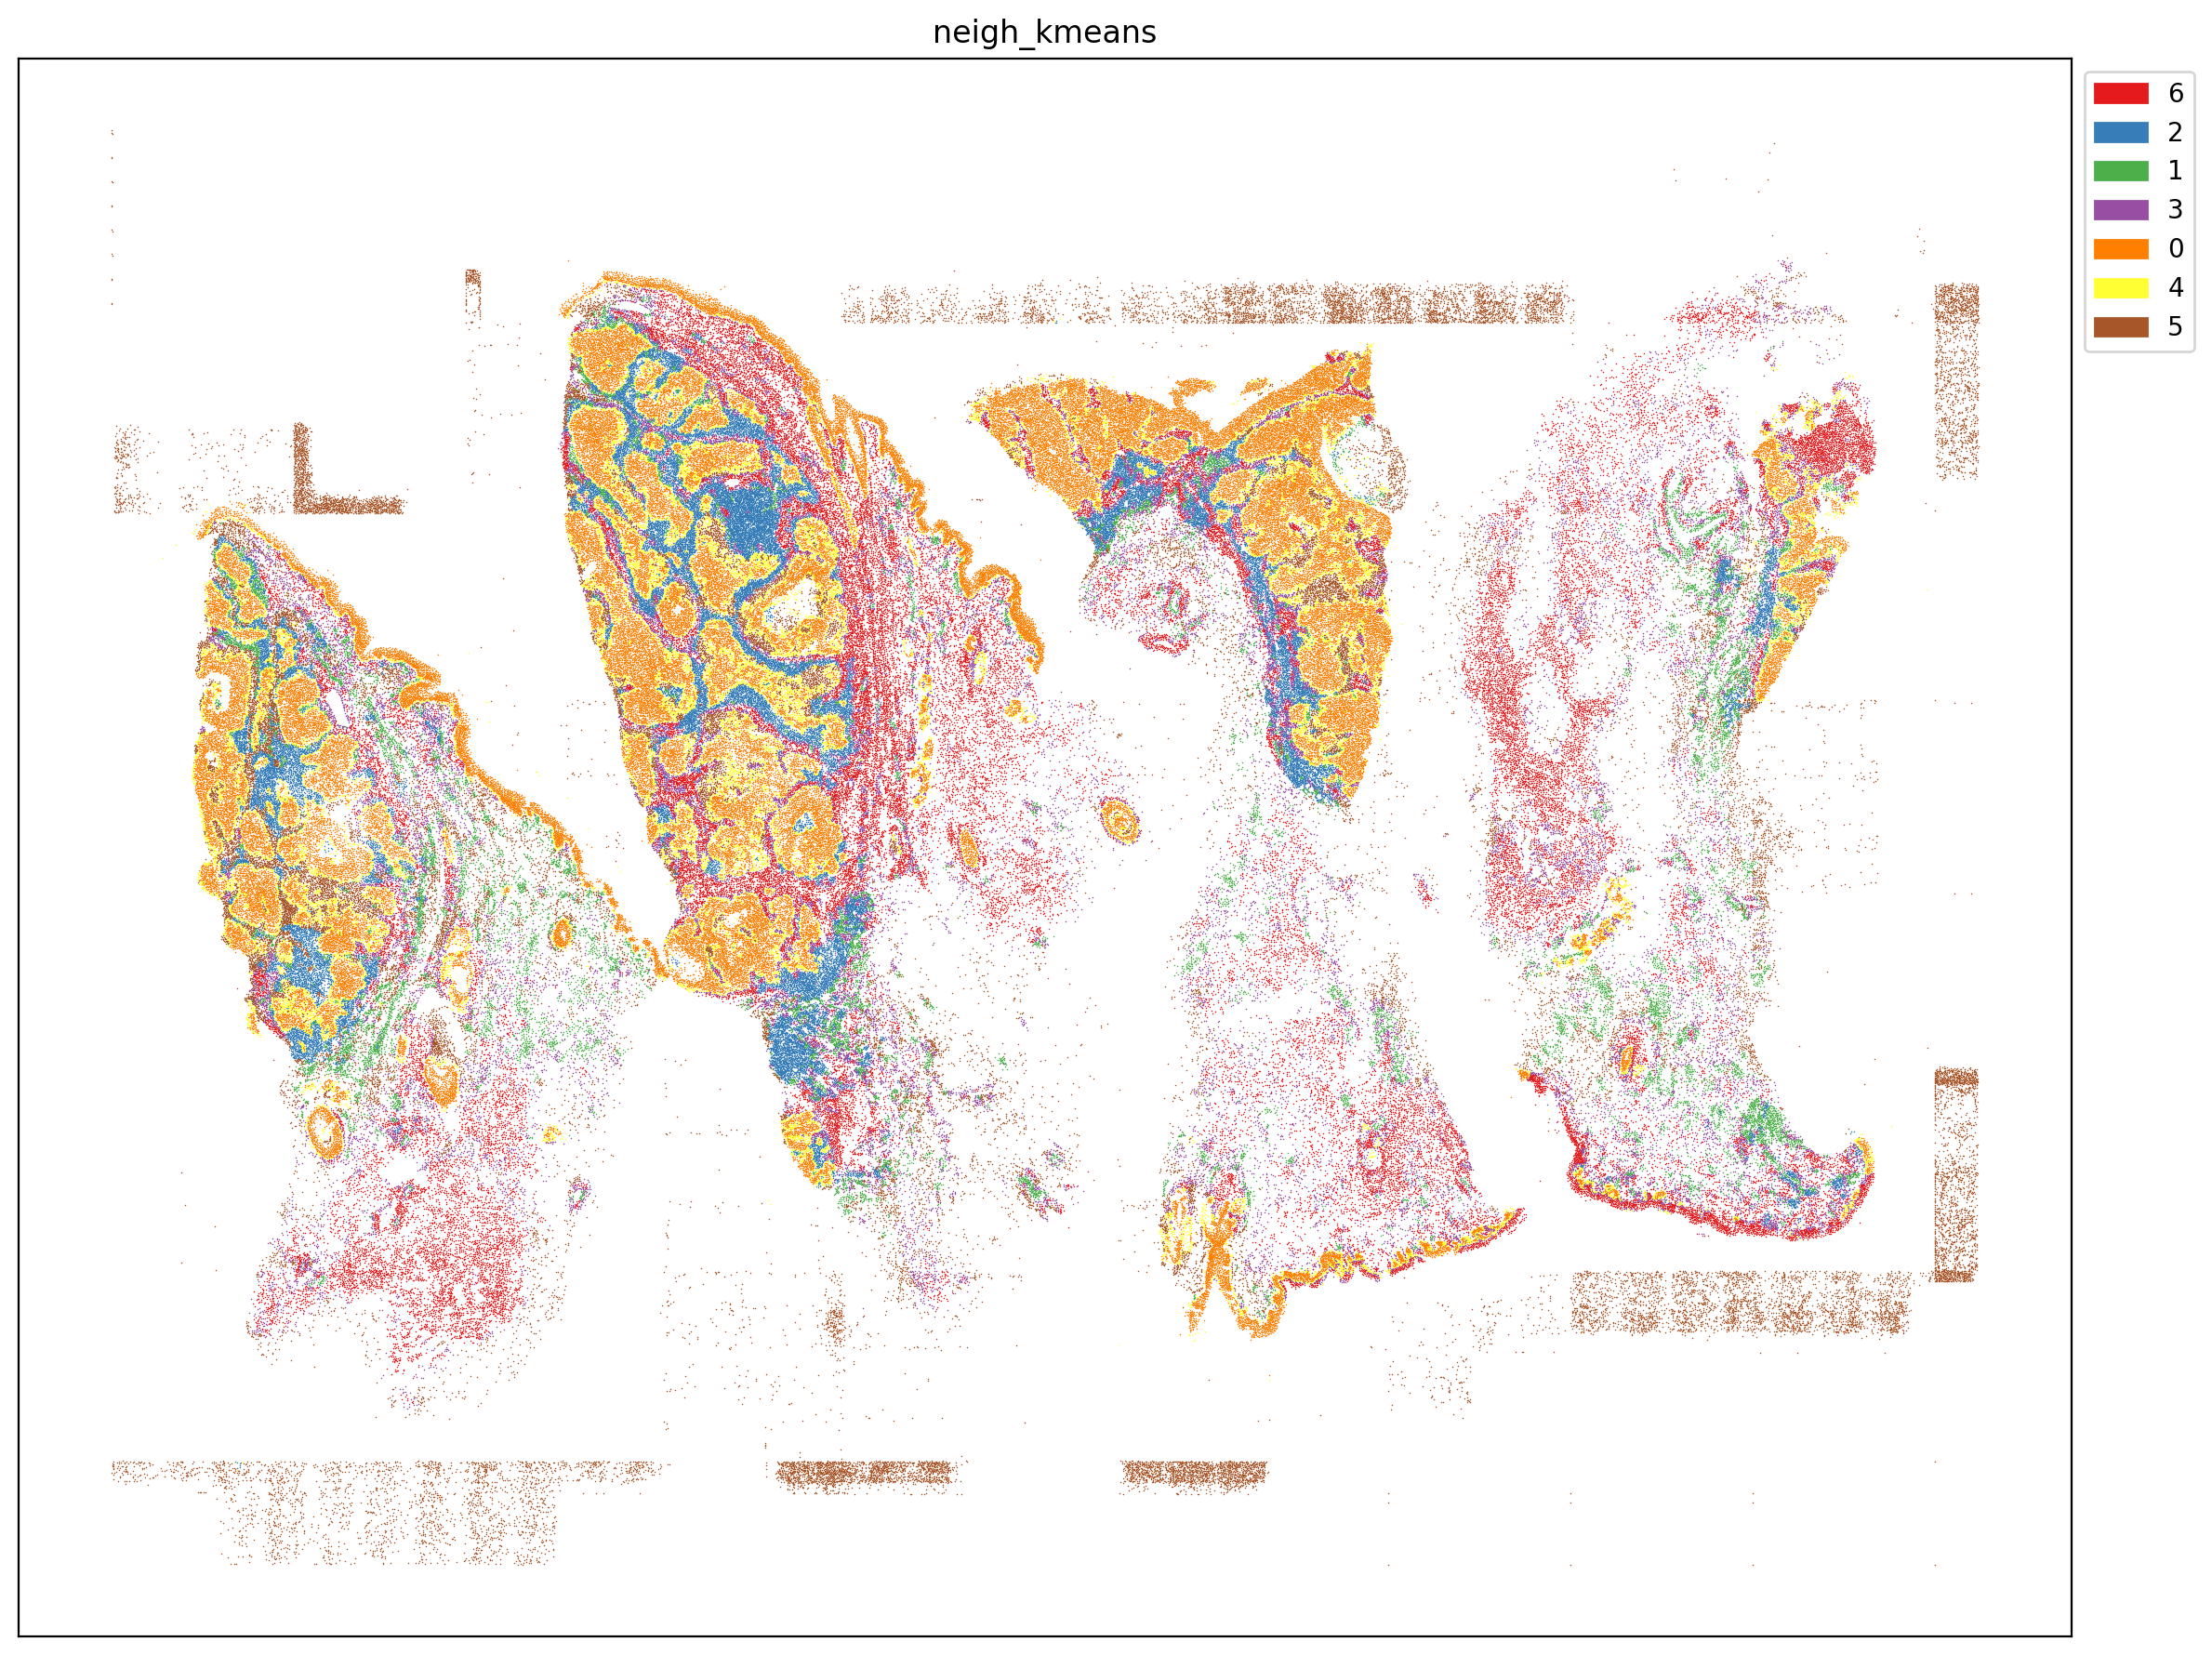

In [22]:
sm.pl.spatial_scatterPlot (adata, colorBy=['neigh_kmeans'], figsize=(12,9), s=0.3, fontsize=10, catCmap='Set1')

In [23]:
adata.write("/Volumes/RD_Coscia/Jose/P26_BCCN/P26E11_Gating_993/quant/20240905_993_gate_filtered_figures.h5ad")